In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import os
import matplotlib as mpl
from PIL import Image
from palettable.cmocean.sequential import Deep_20
deep = mcolors.ListedColormap(Deep_20.mpl_colors)
import glob
from matplotlib import colors
from matplotlib.colors import LogNorm
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.colors import TwoSlopeNorm
import h5py
from matplotlib.lines import Line2D

/home/cneumaie/miniconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Code for calculating data for Figures 4 and S4



In [3]:
alt = np.array([  -25,    25,    75,   125,   175,   225,   275,   325,   375,
         425,   475,   525,   575,   625,   675,   725,   775,   825,
         875,   925,   975,  1025,  1075,  1125,  1175,  1225,  1275,
        1325,  1375,  1425,  1475,  1525,  1575,  1625,  1675,  1725,
        1775,  1825,  1875,  1925,  1975,  2025,  2075,  2125,  2175,
        2225,  2275,  2325,  2375,  2425,  2475,  2525,  2575,  2625,
        2675,  2725,  2775,  2825,  2875,  2925,  2975,  3025,  3075,
        3125,  3175,  3225,  3275,  3325,  3375,  3425,  3475,  3525,
        3575,  3625,  3675,  3725,  3775,  3825,  3875,  3925,  3975,
        4025,  4077,  4129,  4183,  4237,  4293,  4349,  4407,  4467,
        4527,  4589,  4651,  4715,  4781,  4847,  4915,  4985,  5055,
        5127,  5201,  5276,  5352,  5430,  5510,  5591,  5674,  5758,
        5844,  5932,  6022,  6114,  6207,  6302,  6399,  6498,  6599,
        6702,  6807,  6914,  7023,  7134,  7248,  7364,  7483,  7604,
        7727,  7852,  7980,  8111,  8244,  8380,  8519,  8660,  8805,
        8952,  9103,  9256,  9413,  9572,  9735,  9900, 10069, 10242,
       10418, 10597, 10780, 10967, 11156, 11350, 11549, 11749, 11949,
       12149, 12349, 12549, 12749, 12949, 13149, 13349])

In [4]:
def get_depth_extra(depth_array):
    '''creates a new colomn for the equivalent CP1 depth calculation'''
    temp_list = [5,10,20]
    time_list = [30,60,90, 120]
    wind_list = ['placeholder', 'u0']
    depth_array_2 = np.zeros((len(wind_list),len(temp_list),len(temp_list),len(time_list), 3,50))
    depth_array_2[:,:,:,:,:-1] = np.copy(depth_array)
    for w,wind in enumerate(wind_list):
            for c,CP1_temp in enumerate(temp_list):
                for k,CP2_temp in enumerate(temp_list):
                    for t,time in enumerate(time_list):
                            depth_array_2[w,c,k,t,2,:] = np.copy(depth_array[w,k,k,-1,0])  ### Setting CP1 depth to be the CP1 depth of the same strength as CP2
    return depth_array_2

In [5]:
def load_depth_array(filePath, mode = 0):
    '''loads depth array as an xarray from a file'''
    if mode ==0:
        temp_xr = xr.open_dataset(filePath)
        depth_array = temp_xr["__xarray_dataarray_variable__"].as_numpy()
    elif mode ==1:
        depth_file = h5py.File(filePath)
        depth_array = np.array(depth_file["depths"])
        depth_file.close()
        
    depth_array2 = get_depth_extra(depth_array)
    
    return depth_array2

In [6]:
filePaths = sorted(glob.glob(f"/moonbow/cneumaie/CP_train_derecho/processed/*"))
temp_list = [5,10,20]
time_list = [30,60,90, 120]
wind_list = ['placeholder', 'u0']
s_indicies_array = np.zeros((len(wind_list),len(temp_list),len(temp_list),len(time_list),50,4))
n_indicies_array  = np.zeros((len(wind_list),len(temp_list),len(temp_list),len(time_list),50,4))
for filePath in filePaths:
    outfilename = filePath
    if "30" in outfilename:
        cp2_start = 8
    elif "60" in outfilename:
        cp2_start = 14
    elif "90" in outfilename:
        cp2_start = 20
    elif "120" in outfilename:
        cp2_start = 26 

    ###Loop through all variations and perform depth and environment calculations for the case that matches the filePath
    for w,wind in enumerate(wind_list):
        for c,CP1_temp in enumerate(temp_list):
            for k,CP2_temp in enumerate(temp_list):
                for t,time in enumerate(time_list):
                    if f"CP1_{CP1_temp}_CP2_{CP2_temp}_{time:03}_{wind}" in filePath:
                        outfilename2 = f"./cpfile_edges_v7/cpfile_CP1_{CP1_temp}k_CP2_{CP2_temp}k_{time:03}min_{wind}_v2.h5"
                        outfilename = filePath
                        test_dataset = h5py.File(outfilename2, 'r')
                        cp_edges_n= np.array(test_dataset['cp_edges_n'])
                        cp_edges_s= np.array(test_dataset['cp_edges_s'])
                        test_dataset.close()
                        
                        s_indicies_array[w,c,k,t,:len(cp_edges_s[:,0]),:] = cp_edges_s
                        n_indicies_array[w,c,k,t,:len(cp_edges_n[:,0]),:] = cp_edges_n

In [7]:
s_indicies_array_2 = np.moveaxis(s_indicies_array, [-2,-1], [-1,-2])
n_indicies_array_2 = np.moveaxis(n_indicies_array, [-2,-1], [-1,-2])

In [8]:
speed_filePath = f"./all_cp_speeds_v2.h5"
speed_dataset = h5py.File(speed_filePath, 'r')
cp_speeds_n = np.array(speed_dataset["cp_speeds_n"])
cp_speeds_s = np.array(speed_dataset["cp_speeds_s"])
avg_speeds = np.array(speed_dataset["cp_speeds_avg"])
speed_dataset.close()

In [9]:
test2 = h5py.File(f"./envir_cps_v3_min.h5")
thv_bar2 = np.array(test2["thv_bar"])
u_bar2 = np.array(test2["u_bar"])
v_bar2 = np.array(test2["v_bar"])
test2.close()

In [10]:
tindex_l = np.arange(0,4) #index for each initialization time
cp_start_l = [0,8,14,20,26] # start indexes for when each CP2 starts to be tracked

In [11]:
thv_thresholds = np.arange(0.6,1.1,0.2)  ## 0.8K thv deficit used for figure 4, 0.6 and 1 K used for significance testing
# thv_thresholds = np.arange(0.8,1,0.2) ## 
q = 95 # quantile of depths used to define the maximum edge of the cold pool
filepath_list_1 = [f"./cpdepths_all_rkw/thv{round(thv,2):03}_q{q}" for thv in thv_thresholds]
filepath_list = [f"/home/cneumaie/Scripts/cpdepths_test_files_time_v11_95/thv{round(thv,2):03}_q{q}.h5" for thv in thv_thresholds]
depth_array_list = [load_depth_array(filePath, mode =1) for filePath in filepath_list]  ###load the edge depths arrays to make significance masls

In [12]:
test = h5py.File("./envir_cps_rkw_va1.h5", 'r')
thv_bar = np.array(test["thv_bar"])
thv_prime = np.array(test["thv_prime"])
u_bar = np.array(test["u_bar"])
v_bar = np.array(test["v_bar"])
test.close()

In [13]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def calc_C(theta_prime, theta_bar,H):
    '''calculates cold pool intensity given a (virtual) potential temperature
        difference array, a theta_bar value, and a depth H'''
    C_array_temp = np.zeros(100)
    for z in range(1,H+1):
        # print(z,theta_bar[z])
        if theta_bar[z] == 0:
            B = np.nan
        else:
            B = 9.8*(theta_prime[z]/theta_bar[z])

        C_temp = B

        C_array_temp[z] = -np.nanmean(C_temp[-50:])

    C_time_trapz = 0.732*np.sqrt(np.nansum(C_array_temp)*50)
    ###0.732 avg froude number among the CP1 experiments
    
    return C_time_trapz

def get_theta_prime_t(thv_prime1, s_indicies, n_indicies):
    '''Gets the theta_prime array for the current time
    '''
    
    if np.isnan(s_indicies) == False and np.isnan(n_indicies) == False:

        thv_prime_temp = thv_prime1[:,int(s_indicies):int(n_indicies)+1]

    else:
        thv_prime_temp = [np.nan]
    
    return thv_prime_temp

def calc_avgC(C_array, cp2_start, time_avg,time_start, mode):
    '''calculates the avg cold pool intensity over time
       time_avg is the time period to average over in number of indicies
       cp2_start is the index of the CP2 release time + 10 minutes 
       time_start is the first timestep to calculate the time average over
       cp_speed_n and cp_speed_s are the arays calculated in calc_cpspeed'''
    
    cp2_start_speed = cp2_start+time_start

    if mode == "mean":
        cp1_avg_C = np.nanmean(C_array[0,time_start+2:time_start+time_avg+2]) ##this should return one value for cp1
        cp2_avg_C = np.nanmean(C_array[1,cp2_start_speed:cp2_start_speed+time_avg]) ##this should return one value for cp2
    elif mode == "max":
        cp1_avg_C = np.nanmax(C_array[0,time_start:time_start+time_avg]) ##this should return one value for cp1
        cp2_avg_C = np.nanmax(C_array[1,cp2_start_speed:cp2_start_speed+time_avg]) ##this should return one value for cp2
    
    return cp1_avg_C, cp2_avg_C

def get_all_C(thv_prime_arr, thv_bar_arr, depth_arr, s_indicies_arr, n_indicies_arr, time_avg):
    ''' calculates an array of max C values for each CP'''
    temp_list = [5,10,20]
    time_list = [30,60,90, 120]
    wind_list = ['placeholder', 'u0']
    C_array = np.zeros((len(wind_list),len(temp_list),len(temp_list),len(time_list),3,50))
    C_array_avg = np.zeros((len(wind_list),len(temp_list),len(temp_list),len(time_list),3))
    
    ubar_avgz_arr = np.zeros((len(wind_list),len(temp_list),len(temp_list),len(time_list),3, 50))
    vbar_avgz_arr = np.zeros((len(wind_list),len(temp_list),len(temp_list),len(time_list),3, 50))
    
    ubar_avg_arr = np.zeros((len(wind_list),len(temp_list),len(temp_list),len(time_list),3))
    vbar_avg_arr = np.zeros((len(wind_list),len(temp_list),len(temp_list),len(time_list),3))
    
    cp2_start_list = [8,14,20,26]
    time_start = 0
    for w,wind in enumerate(wind_list):
        for c,CP1_temp in enumerate(temp_list):
            for k,CP2_temp in enumerate(temp_list):
                for t,time in enumerate(time_list):
                    print(wind,CP1_temp,CP2_temp,time)
                    cp2_start = cp2_start_list[t]

                    theta_prime_curr = thv_prime_arr[w,c,k,t]
                    thv_bar_curr = thv_bar_arr[w,c,k,t]
                    depth_curr = depth_arr[w,c,k,t]

                    s_indicies_curr = s_indicies_arr[w,c,k,t]
                    n_indicies_curr = n_indicies_arr[w,c,k,t]
                    for t_temp in range(len(thv_bar_curr[0])-1):
                        if t_temp < cp2_start:
                            cp_ind = 0
                            t_cp = t_temp
                            s_indicies = s_indicies_curr[cp_ind][t_cp]
                            n_indicies = n_indicies_curr[cp_ind][t_cp]
                            t_du = t_temp
                        else:
                            cp_ind = 1
                            t_cp = t_temp-cp2_start
                            t_cp = t_temp
                            t_du =  t_temp-cp2_start
                            s_indicies = s_indicies_curr[cp_ind][t_temp]
                            n_indicies = n_indicies_curr[cp_ind][t_temp]

                        theta_prime = theta_prime_curr[cp_ind][t_cp]
                        thv_bar = thv_bar_curr[cp_ind][t_cp]                        
                        depth = depth_curr[cp_ind][t_du]
                        depth_ind = find_nearest(alt,depth)
                        theta_prime_cp = get_theta_prime_t(theta_prime, s_indicies, n_indicies)
                        ubar_avgz = np.nanmean(u_bar2[w,c,k,t,cp_ind,t_cp,1:depth_ind+1])
                        vbar_avgz = np.nanmean(v_bar2[w,c,k,t,cp_ind,t_cp,1:depth_ind+1])
                        ubar_avgz_arr[w,c,k,t,cp_ind,t_temp] = np.copy(ubar_avgz)
                        vbar_avgz_arr[w,c,k,t,cp_ind,t_temp] = np.copy(vbar_avgz)

                        if len(theta_prime_cp) >1 :

                            C = calc_C(theta_prime_cp, thv_bar, depth_ind)

                        else:
                            C = np.nan
                        C_array[w,c,k,t,cp_ind,t_temp] = np.copy(C)
                    cp1_C_avg, cp2_C_avg = calc_avgC(C_array[w,c,k,t], cp2_start, time_avg, time_start, mode = "mean")
                    cp1_ubar_avg, cp2_ubar_avg = calc_avgC(ubar_avgz_arr[w,c,k,t], cp2_start, time_avg, time_start, mode = "mean")
                    cp1_vbar_avg, cp2_vbar_avg = calc_avgC(vbar_avgz_arr[w,c,k,t], cp2_start, time_avg, time_start, mode = "mean")
                    
                    
                    C_array_avg[w,c,k,t,0] = np.copy(cp1_C_avg)
                    C_array_avg[w,c,k,t,1] = np.copy(cp2_C_avg)
                    
                    ubar_avg_arr[w,c,k,t,0] = np.copy(cp1_ubar_avg)
                    ubar_avg_arr[w,c,k,t,1] = np.copy(cp2_ubar_avg)
                    
                    vbar_avg_arr[w,c,k,t,0] = np.copy(cp1_vbar_avg)
                    vbar_avg_arr[w,c,k,t,1] = np.copy(cp2_vbar_avg)
                        
    return C_array, C_array_avg,ubar_avg_arr, vbar_avg_arr
                    

## Calculate C

In [14]:
t_avg = 10   ###50 minutes
C_array, C_array_avg, ubar_avg_arr, vbar_array_avg  = get_all_C(thv_prime, thv_bar, depth_array_list[1], s_indicies_array_2, n_indicies_array_2, t_avg)

placeholder 5 5 30
placeholder 5 5 60
placeholder 5 5 90
placeholder 5 5 120
placeholder 5 10 30
placeholder 5 10 60
placeholder 5 10 90
placeholder 5 10 120

/tmp/ipykernel_1174961/4108624581.py:21: RuntimeWarning: invalid value encountered in sqrt
  C_time_trapz = 0.732*np.sqrt(np.nansum(C_array_temp)*50)
/tmp/ipykernel_1174961/4108624581.py:106: RuntimeWarning: Mean of empty slice
  ubar_avgz = np.nanmean(u_bar2[w,c,k,t,cp_ind,t_cp,1:depth_ind+1])
/tmp/ipykernel_1174961/4108624581.py:107: RuntimeWarning: Mean of empty slice
  vbar_avgz = np.nanmean(v_bar2[w,c,k,t,cp_ind,t_cp,1:depth_ind+1])
/tmp/ipykernel_1174961/4108624581.py:50: RuntimeWarning: Mean of empty slice
  cp2_avg_C = np.nanmean(C_array[1,cp2_start_speed:cp2_start_speed+time_avg]) ##this should return one value for cp2



placeholder 5 20 30
placeholder 5 20 60
placeholder 5 20 90
placeholder 5 20 120
placeholder 10 5 30
placeholder 10 5 60
placeholder 10 5 90
placeholder 10 5 120
placeholder 10 10 30
placeholder 10 10 60
placeholder 10 10 90
placeholder 10 10 120
placeholder 10 20 30
placeholder 10 20 60
placeholder 10 20 90
placeholder 10 20 120
placeholder 20 5 30
placeholder 20 5 60
placeholder 20 5 90
placeholder 20 5 120
placeholder 20 10 30
placeholder 20 10 60
placeholder 20 10 90
placeholder 20 10 120
placeholder 20 20 30
placeholder 20 20 60
placeholder 20 20 90
placeholder 20 20 120
u0 5 5 30
u0 5 5 60
u0 5 5 90
u0 5 5 120
u0 5 10 30
u0 5 10 60
u0 5 10 90
u0 5 10 120
u0 5 20 30
u0 5 20 60
u0 5 20 90
u0 5 20 120
u0 10 5 30
u0 10 5 60
u0 10 5 90
u0 10 5 120
u0 10 10 30
u0 10 10 60
u0 10 10 90
u0 10 10 120
u0 10 20 30
u0 10 20 60
u0 10 20 90
u0 10 20 120
u0 20 5 30
u0 20 5 60
u0 20 5 90
u0 20 5 120
u0 20 10 30
u0 20 10 60
u0 20 10 90
u0 20 10 120
u0 20 20 30
u0 20 20 60
u0 20 20 90
u0 20 20 120

In [15]:
savePath = "./CPTrain_Figs/"

In [16]:
def depths_sorted(depth_array, mode = "NoWind"):
    '''calculates the relative differences of the mean edge depths between cp2 and the same relative cp1
        for each cp2 case within each wind profile'''
    data_array2 = np.nanmean(depth_array[:,:,:,:,:,1:11], axis = 5)
    if mode =="NoWind":
        plotted_20k = np.transpose((data_array2[1,:,2,:,1,]-data_array2[1,:,2,:,2,])/data_array2[1,:,2,:,2,])*100
        cp1_20k = round(data_array2[1,2,2,-1,2,],2)
        plotted_10k = np.transpose((data_array2[1,:,1,:,1,]-data_array2[1,:,1,:,2,])/data_array2[1,:,1,:,2,])*100
        cp1_10k = round(data_array2[1,1,1,-1,2,],2)
        plotted_5k = np.transpose((data_array2[1,:,0,:,1,]-data_array2[1,:,0,:,2,])/data_array2[1,:,0,:,2,])*100
        cp1_5k = round(data_array2[1,0,0,-1,2,],2)

    return plotted_5k, plotted_10k, plotted_20k  

def make_filter(depths_06,depths_08, depths_1):
    '''makes a mask for depths filter based on if the results are within a consistency threshold 
        of relative differences'''
    mask = np.zeros((4,3))
    mask[:,:] = np.nan
    for j in range(4):
        for i in range(3):
            temp_06 = depths_06[j,i]
            temp_08 = depths_08[j,i]
            temp_1 = depths_1[j,i]
            temp_all = np.array((temp_06, temp_08, temp_1))
            temp_min = np.min(temp_all)
            temp_max = np.max(temp_all)
            if len(np.unique(np.sign(temp_all))) == 2 or temp_max-temp_min > 15 or np.isnan(temp_all).any():
                
                mask[j,i] = np.nan
            else:
                mask[j,i] = 1
    return mask
def depths_filter(depths_array_06, depths_array_08, depths_array_1, mode="NoWind"):
    '''creates an array that judges depth based on consistency of using different thv thresholds
        for each sorted array created in depths_sorted'''
    depths_06_5k, depths_06_10k, depths_06_20k = depths_sorted(depths_array_06,mode)
    depths_08_5k, depths_08_10k, depths_08_20k = depths_sorted(depths_array_08,mode)
    depths_1_5k, depths_1_10k, depths_1_20k = depths_sorted(depths_array_1,mode)
    mask_5k = make_filter(depths_06_5k, depths_08_5k, depths_1_5k)
    mask_10k = make_filter(depths_06_10k, depths_08_10k, depths_1_10k)
    mask_20k = make_filter(depths_06_20k, depths_08_20k, depths_1_20k)
    return mask_5k, mask_10k, mask_20k


mask_5k_u0, mask_10k_u0, mask_20k_u0 = depths_filter(depth_array_list[0], depth_array_list[1], ## make the masks for the cases
                                                     depth_array_list[2], mode = "NoWind")

/tmp/ipykernel_1174961/3409778934.py:4: RuntimeWarning: Mean of empty slice
  data_array2 = np.nanmean(depth_array[:,:,:,:,:,1:11], axis = 5)


In [17]:
wind = 1
cp1_T = 0
cp2_T = 0
time = 0
C_real = np.array([avg_speeds[wind,cp1_T,cp2_T,-1,0], avg_speeds[wind,cp1_T+1,cp2_T,-1,0], avg_speeds[wind,cp1_T+2,cp2_T,-1,0]])
C_theor_long = np.array([C_array_avg[wind,cp1_T,cp2_T,-1,0], C_array_avg[wind,cp1_T+1,cp2_T,-1,0], C_array_avg[wind,cp1_T+2,cp2_T,-1,0]])

m_long, b_long = np.polyfit(C_real, C_theor_long, deg=1)

x = np.arange(0, 17)
y_long = m_long*x+b_long

time = 0

In [18]:
C_pred_long = m_long*avg_speeds+b_long
C_wind_long = C_array_avg+vbar_array_avg
C_wind_reduced_long = C_array_avg+vbar_array_avg*0.75
wind_red_rel_long = (C_wind_reduced_long-C_array_avg)/C_wind_reduced_long*100
sbl_rel_long = (C_wind_reduced_long-C_pred_long)/C_wind_reduced_long * 100

/tmp/ipykernel_1174961/1312388005.py:4: RuntimeWarning: invalid value encountered in divide
  wind_red_rel_long = (C_wind_reduced_long-C_array_avg)/C_wind_reduced_long*100
/tmp/ipykernel_1174961/1312388005.py:5: RuntimeWarning: divide by zero encountered in divide
  sbl_rel_long = (C_wind_reduced_long-C_pred_long)/C_wind_reduced_long * 100


In [19]:
wind_red_rel_5k_long = np.transpose(wind_red_rel_long[1,:,0,:,1])
wind_red_rel_10k_long = np.transpose(wind_red_rel_long[1,:,1,:,1])
wind_red_rel_20k_long = np.transpose(wind_red_rel_long[1,:,2,:,1])

sbl_rel_5k_long = np.transpose(sbl_rel_long[1,:,0,:,1])
sbl_rel_10k_long = np.transpose(sbl_rel_long[1,:,1,:,1])
sbl_rel_20k_long = np.transpose(sbl_rel_long[1,:,2,:,1])

In [20]:
style = "/home/cneumaie/Scripts/Styles/christine-paperlight.mpstyle"

plt.style.use(style)

Duplicate key in file '/home/cneumaie/Scripts/Styles/christine-paperlight.mpstyle', line 15 ("xtick.color: 'k'")
Duplicate key in file '/home/cneumaie/Scripts/Styles/christine-paperlight.mpstyle', line 16 ("ytick.color: 'k'")
Duplicate key in file '/home/cneumaie/Scripts/Styles/christine-paperlight.mpstyle', line 27 ('axes.edgecolor:222222')


## Code for plotting Figure 4

In [21]:
savePath = "./CPTrain_Figs/"


from matplotlib.pyplot import rcParams
import matplotlib.cm as cm

plt.rcParams['font.size'] = 29
def plot_rel_contribution(plotted_5k, plotted_10k, plotted_20k,mask_list, time_avg,time_start,axes,savePath, mode = "Wind Speed", mode2 = "mean"):
    '''Plots Figure 3a-c (if mode == "V") or 3d-f (if mode =="Stability")
    '''

    if mode =="Wind Speed":
        label1 = "a)"
        label2 = "b)"
        label3 = "c)"
        ax1 = axes[0][0]
        ax2 = axes[0][1]
        ax3 = axes[0][2]
        save_prefix = "4a-c"
    elif mode =="Stability":
        label1 = "d)"
        label2 = "e)"
        label3 = "f)"
        ax1 = axes[1][0]
        ax2 = axes[1][1]
        ax3 = axes[1][2]
        save_prefix = "4d-f"

    mask_5k = mask_list[0]
    mask_10k = mask_list[1]
    mask_20k = mask_list[2]
    print(f"time_start {(time_start)*5+10} min,time avg {time_avg*5} min {mode2} {mode}")
    # cmap = "RdBu_r"
    cmap = cm.RdBu_r  
    cmap.set_bad('gray') # Set NaN values to gray
    norm = TwoSlopeNorm(vmin = -55, vcenter = 0, vmax = 55) #TwoSlopeNorm(vmin = -50, vcenter = 0, vmax = 50)
    
    

    c = ax1.imshow(plotted_5k, cmap = cmap, norm = norm)
    ax1.set_yticks(ticks = np.arange(4),labels =[30,60,90,120])
    if mode == "Stability":
        ax1.set_xticks(ticks = np.arange(3),labels = [-5,-10,-20])
    else:
        ax1.set_xticks(ticks = np.arange(3),labels = ['']*3)
    df = pd.DataFrame(plotted_5k)

    # Replace NaNs with 'N/A'
    df.fillna('N/A', inplace=True)

    # Convert back to a NumPy array for labels
    plotted_5k_label = df.values
    for j in range(4):
        for i in range(3):
            if np.abs(plotted_5k[j,i]) >30:
                      color = "white"
            else:
                      color = "k"
            if mask_5k[j,i] ==1:
                weight = "bold"
            else:
                weight = "normal"
            if type(plotted_5k_label[j,i]) != str: #Check to make sure value is a number for formatting
                ax1.text(i,j,"{:.1f}".format(plotted_5k_label[j,i]),
                         horizontalalignment='center',verticalalignment='center',
                         color=color, weight = weight)
            # else:
            #     ax1.text(i,j,"{:}".format(plotted_5k_label[j,i]),
            #              horizontalalignment='center',verticalalignment='center',
            #              color='gray')
    

    ax1.set_ylabel("Time between CPs (min)")
    ax1.set_title(f"CP2 -5K", fontsize = 31)
    ax1.text(-.06, 1.11, label1, ha='left', va='top', weight = 'bold', size = 35, transform=ax1.transAxes)
    
    df = pd.DataFrame(plotted_10k)

    # Replace NaNs with 'N/A'
    df.fillna('N/A', inplace=True)

    # Convert back to a NumPy array (if needed)
    plotted_10k_label = df.values

    c = ax2.imshow(plotted_10k, cmap = cmap, norm = norm)
    # ax2.set_yticks(ticks = np.arange(4),labels =[30,60,90,120])
    ax2.set_yticks(ticks = np.arange(4))
    ax2.set_yticklabels(['']*4)
    if mode == "Stability":
        ax2.set_xticks(ticks = np.arange(3),labels = [-5,-10,-20])
    else:
        ax2.set_xticks(ticks = np.arange(3),labels = ['']*3)
    for j in range(4):
        for i in range(3):
            if np.abs(plotted_10k[j,i]) >30:
                      color = "white"
            else:
                      color = "k"
            if mask_10k[j,i] ==1:
                weight = "bold"
            else:
                weight = "normal"
            if type(plotted_10k_label[j,i]) != str: #Check to make sure value is a number for formatting
                ax2.text(i,j,"{:.1f}".format(plotted_10k_label[j,i]),
                         horizontalalignment='center',verticalalignment='center',
                         color=color, weight = weight)
            # else:
            #     ax2.text(i,j,"{:}".format(plotted_10k_label[j,i]),
            #              horizontalalignment='center',verticalalignment='center',
            #              color='grey')
    

    ax2.set_title(f"CP2 -10K", fontsize = 31)
    if mode =="Stability":
        ax2.set_xlabel("CP1 Temperature (K)", fontsize = 35)
    ax2.text(-.06, 1.11, label2, ha='left', va='top', weight = 'bold', size = 35, transform=ax2.transAxes)
    ax1.text(
    x=-0.5,  # Slightly outside the left axis (negative x-value)
    y=0.5,   # Middle of the y-axis
    s=mode,  # The text content
    rotation=90,  # Rotate the text 90 degrees
    verticalalignment='center',  # Centered vertically
    horizontalalignment='center',  # Centered horizontally
    fontsize=40,  # Set the font size
    weight = "bold",
    transform=ax1.transAxes  # Use axis coordinates for positioning
    )
    # ax2.text(0.4, 1.3,mode,ha='center', va='top', weight = 'bold', size = 38, transform = ax2.transAxes)
    
    df = pd.DataFrame(plotted_20k)

    # Replace NaNs with 'N/A'
    df.fillna('N/A', inplace=True)

    # Convert back to a NumPy array (if needed)
    plotted_20k_label = df.values
    # plt.subplot(133)

    c = ax3.imshow(plotted_20k, cmap = cmap, norm = norm)
    # ax3.set_yticks(ticks = np.arange(4),labels =[30,60,90,120])
    ax3.set_yticks(ticks = np.arange(4))
    ax3.set_yticklabels(['']*4)
    if mode == "Stability":
        ax3.set_xticks(ticks = np.arange(3),labels = [-5,-10,-20])
    else:
        ax3.set_xticks(ticks = np.arange(3),labels = ['']*3)

    for j in range(4):
        for i in range(3):
            if np.abs(plotted_20k[j,i]) >30:
                      color = "white"
            else:
                      color = "k"
            if mask_20k[j,i] ==1:
                weight = "bold"
            else:
                weight = "normal"
            if type(plotted_20k_label[j,i]) != str: #Check to make sure value is a number for formatting
                ax3.text(i,j,"{:.1f}".format(plotted_20k_label[j,i]),
                         horizontalalignment='center',verticalalignment='center',
                         color=color, weight = weight)
#             else:
#                 ax3.text(i,j,"{:}".format(plotted_20k_label[j,i]),
#                          horizontalalignment='center',verticalalignment='center',
#                          color='grey')
    

    ax3.set_title(f"CP2 -20K ", fontsize = 31)
    ax3.text(-.06, 1.11, label3, ha='left', va='top', weight = 'bold', size = 35, transform=ax3.transAxes)
    

    return c

time_start 10 min,time avg 50 min mean Wind Speed
time_start 10 min,time avg 50 min mean Stability


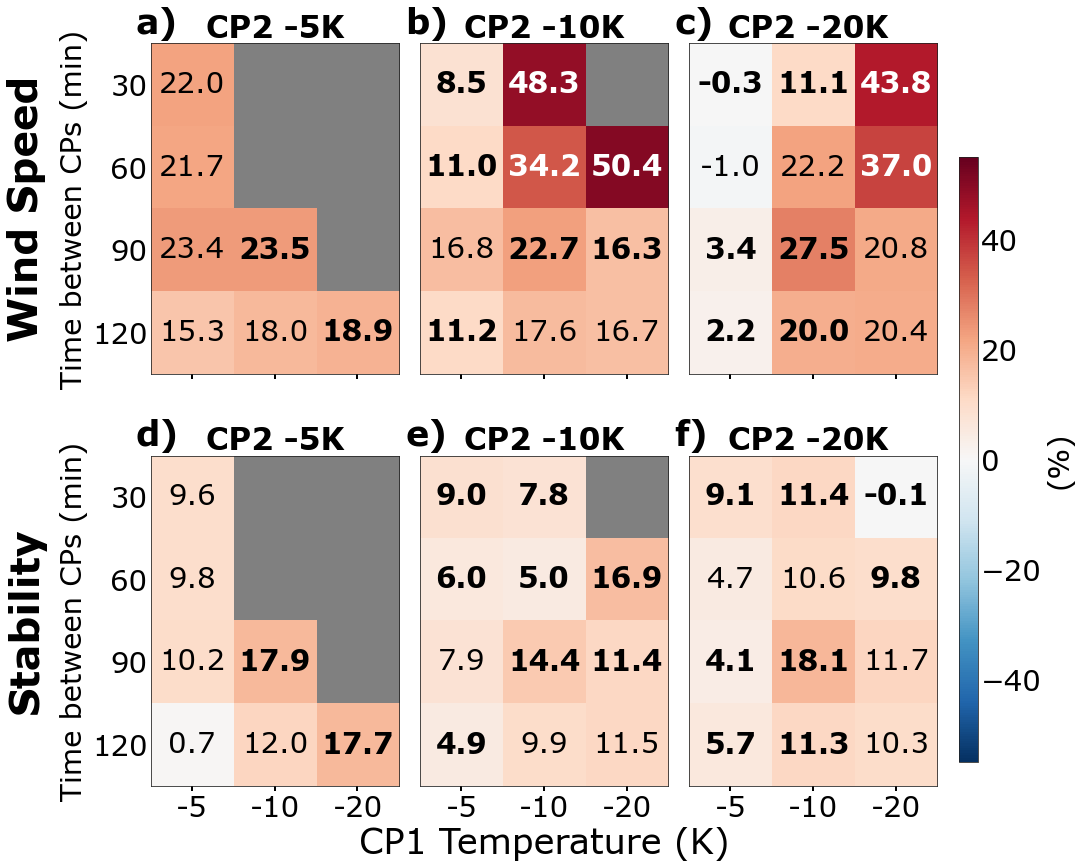

In [28]:

from matplotlib.pyplot import rcParams
import matplotlib.cm as cm

plt.rcParams['font.size'] = 29
time_avg_list = np.arange(10,11) #averaging over 10 indicies, which is 50 minutes for this simulation
time_start_list = np.arange(0,1) #start averaging at the first available speed timestep
mode_list = ["mean"]
fig, axes= plt.subplots(2,3,figsize = (13,12), constrained_layout = True)
mask_list_u0 = [mask_5k_u0, mask_10k_u0, mask_20k_u0]
for time_avg in time_avg_list:
    for time_start in time_start_list:
        for mode2 in mode_list:
            c=plot_rel_contribution(wind_red_rel_5k_long, wind_red_rel_10k_long, wind_red_rel_20k_long,mask_list_u0,time_avg,time_start,axes,savePath = savePath, mode = "Wind Speed", mode2 = mode2)
            c=plot_rel_contribution(sbl_rel_5k_long, sbl_rel_10k_long, sbl_rel_20k_long,mask_list_u0, time_avg,time_start,axes,savePath = savePath, mode = "Stability", mode2 = mode2)
            cax = fig.add_axes([1.02, 0.12, 0.02, 0.7])
            fig.colorbar(c, label = f"(%)", fraction=0.046, pad=0.1, cax = cax)
            plt.savefig(f"{savePath}figure4_r2.eps", format = "eps")
            plt.show()
            plt.close()

## Code for Plotting Figure S4

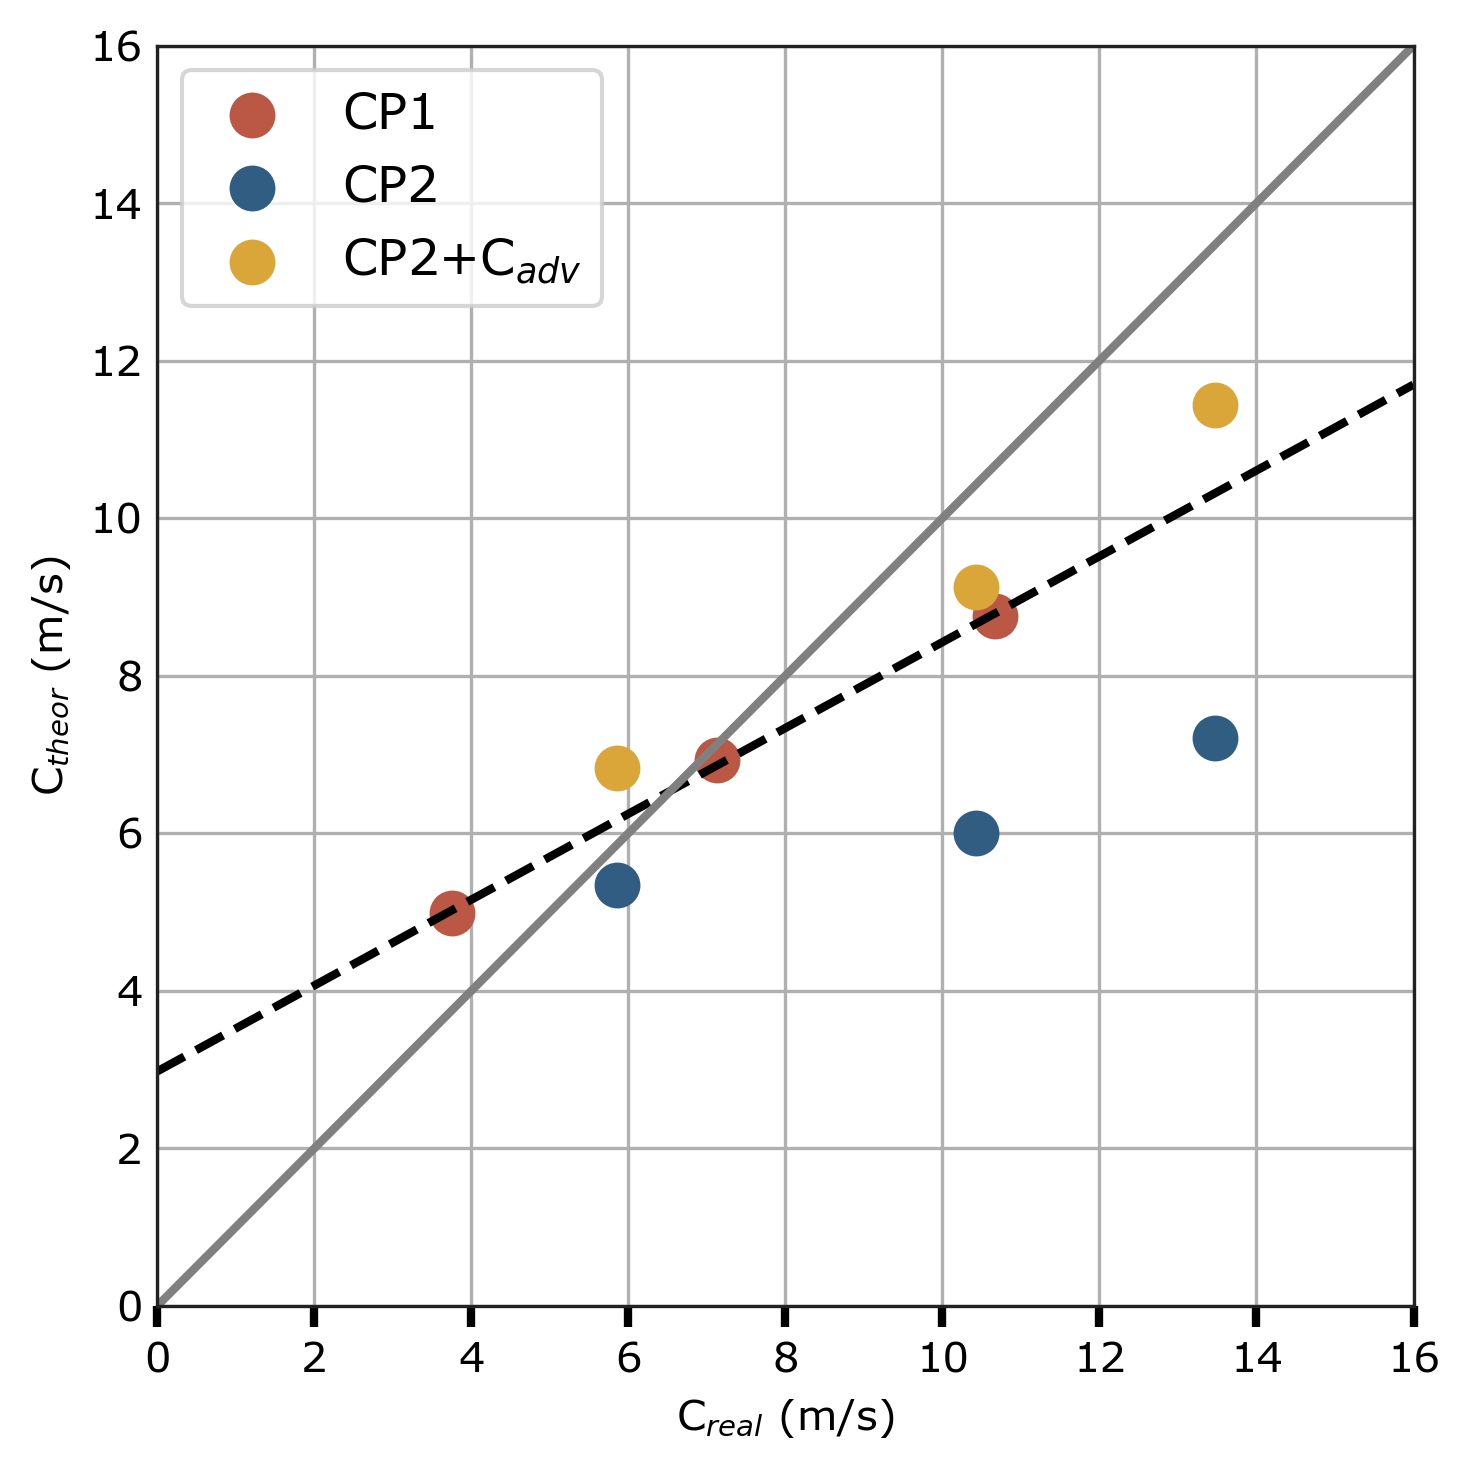

In [24]:
plt.figure(figsize = (5,5), dpi = 300)
time = 1
wind = 1
cp1_T = 0
cp2_T = 0
C_real = np.array([avg_speeds[wind,cp1_T,cp2_T,-1,0], avg_speeds[wind,cp1_T+1,cp2_T,-1,0], avg_speeds[wind,cp1_T+2,cp2_T,-1,0]])
C_theor_long = np.array([C_array_avg[wind,cp1_T,cp2_T,-1,0], C_array_avg[wind,cp1_T+1,cp2_T,-1,0], C_array_avg[wind,cp1_T+2,cp2_T,-1,0]])

m_long, b_long = np.polyfit(C_real, C_theor_long, deg=1)

x = np.arange(0, 17)
y_long = m_long*x+b_long

C_real2 = np.array([avg_speeds[wind,cp1_T,cp2_T,time,1], avg_speeds[wind,cp1_T+1,cp2_T+1,time,1], avg_speeds[wind,cp1_T+2,cp2_T+2,time,1]])
C_theor2 = np.array([C_array_avg[wind,cp1_T,cp2_T,time,1], C_array_avg[wind,cp1_T+1,cp2_T+1,time,1], C_array_avg[wind,cp1_T+2,cp2_T+2,time,1]])
v_real2 = np.array([vbar_array_avg[wind,cp1_T,cp2_T,time,1], vbar_array_avg[wind,cp1_T+1,cp2_T+1,time,1], vbar_array_avg[wind,cp1_T+2,cp2_T+2,time,1]])

plt.scatter(C_real, C_theor_long, label = "CP1", s = 100)
plt.plot(x, y_long, 'k--', linewidth = 2)

plt.scatter(C_real2, C_theor2, label = "CP2", s = 100)
plt.scatter(C_real2, C_theor2+v_real2*0.75, label = r"CP2+C$_{adv}$", s = 100)
plt.xlabel(r"C$_{real}$ (m/s)")
plt.ylabel(r"C$_{theor}$ (m/s)")
plt.legend(loc = "upper left", facecolor = "white", frameon = True)
# plt.title("CP2 60 min")
plt.xlim(0,16)
plt.ylim(0,16)
plt.plot(x,x, 'gray', linewidth = 2)
plt.grid()
plt.show()
plt.close()